In [1]:
%matplotlib inline
from IPython.display import display, Math, Latex, HTML
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed


plt.rcParams['figure.figsize'] = (10,8)

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Показване/скриване на кода."></form>''')

In [2]:
n = 0.02
delta = 0.05
s = 0.2
A = 1
alpha = 0.3
k0 = 1
Tmax = 150

def f(k,TFP,al):
    return TFP*k**al

k = np.arange(0,6,0.1)

In [3]:
def ComputeSSk(s,n,delta,maxk,pf,*args):
    """Computes the steady state capital per capita in the Solow growth model"""
    sol = sp.optimize.brentq(lambda k:s*pf(k,*args)-(n+delta)*k,0.0001,maxk*100)
    return sol

In [4]:
def ComputeCons(S,K,pf,*args):
    """Computes the current consumption per capita"""
    return (1-S)*pf(K,*args) # 

In [5]:
def ComputeSgold(n,delta,maxk,pf,*args):
    """Computes the consumption-maximizing savings rate, s_gold"""
    res = sp.optimize.minimize_scalar(lambda S:-ComputeCons(S,ComputeSSk(S,n,delta,maxk,pf,*args),pf,*args), 
                                      method='bounded', bounds=(0,1))
    return res.x

In [6]:
def plotPFandDepr(s0,n0,delta0,A0,alpha0,s1,n1,delta1,A1,alpha1,kmax):
    try:
        k0ss = ComputeSSk(s0,n0,delta0,kmax,f,A0,alpha0)
        k1ss = ComputeSSk(s1,n1,delta1,kmax,f,A1,alpha1)
    except ValueError:
        print("За тези параметри не може да бъде пресметнато стационарно състояние!")
        return None
    sF0ss = (n0+delta0)*k0ss
    sF1ss = (n1+delta1)*k1ss
    ub = int(round(max(kmax,k0ss,k1ss)))+1
    k = np.arange(0,ub,0.1)
    sF0 = s0*f(k,A0,alpha0)
    ndk0 = (n0+delta0)*k
    sF1 = s1*f(k,A1,alpha1)
    ndk1 = (n1+delta1)*k
    plt.plot(k,sF0,'k-',linewidth=2)
    plt.plot(k,ndk0,'k--',linewidth=1.5)
    
    plt.plot((k0ss, k0ss), (0, sF0ss),'k--')
    plt.text(k0ss+0.01,0.01,r'$k^{*}$',fontsize=18)
    
    plt.plot(k,sF1,'b-',linewidth=2)
    plt.plot(k,ndk1,'b--',linewidth=1.8)

    plt.plot((k1ss, k1ss), (0, sF1ss),'b--')
    plt.text(k1ss+0.01,0.05,r'$k^{**}$',fontsize=18,color = 'b')
    
    plt.xlabel(r'$k$',fontsize = 18)
    plt.show()

In [7]:
def plotConsToScompare(n0,delta0,A0,alpha0,n1,delta1,A1,alpha1,f,maxk):
    """Produces a plot of steady state consumption as a function of savings"""
    Cons0=[]
    Cons1=[]
    Srates = np.arange(0.001,1.01,0.01)
    for S in Srates:
        try:
            Cons0.append(ComputeCons(S,ComputeSSk(S,n0,delta0,maxk,f,A0,alpha0),f,A0,alpha0))
            Cons1.append(ComputeCons(S,ComputeSSk(S,n1,delta1,maxk,f,A1,alpha1),f,A1,alpha1))
        except ValueError:
            print("За тези параметри не може да бъде пресметнато стационарно състояние!")
            return None
    Cons0 = np.array(Cons0)
    Cons1 = np.array(Cons1)
    plt.plot(Srates,Cons0,color='k')
    plt.plot(Srates,Cons1,color='b')
    plt.xlim((0,1))
    plt.ylim(0)
    plt.xlabel(r"$S$",fontsize=18)
    plt.ylabel(r"$C$",rotation=0,fontsize=18,horizontalalignment='right')
    Sgold0 = ComputeSgold(n0,delta0,maxk,f,A0,alpha0)
    Sgold1 = ComputeSgold(n1,delta1,maxk,f,A1,alpha1)
    plt.axvline(x=Sgold0,linewidth=2, color='k')
    plt.text(Sgold0,0.03,r'$S_{gold,0}$',fontsize=18)
    plt.axvline(x=Sgold1,linewidth=2, color='b')
    plt.text(Sgold1,0.13,r'$S_{gold,1}$',fontsize=18,color='b')
    plt.show()

In [8]:
def SolowSols(kinit0,s0,n0,delta0,A0,alpha0, kinit1,s1,n1,delta1,A1,alpha1,Tmax, f, kmax):
    try:
        k0ss = ComputeSSk(s0,n0,delta0,kmax,f,A0,alpha0)
        k1ss = ComputeSSk(s1,n1,delta1,kmax,f,A1,alpha1)
    except ValueError:
        print("За тези параметри не може да бъде пресметнато стационарно състояние!")
        return None
    ymax = max(k0ss,k1ss)+1
    t = np.arange(0,Tmax,0.1)
    def rhs(k,t,s,n,delta,A,alpha):
        return s*f(k,A,alpha)-(n+delta)*k
    k00 = np.array([kinit0])
    k01 = np.array([kinit1])

    y0 = sp.integrate.odeint(rhs,k00,t,args = (s0,n0,delta0,A0,alpha0))
    y1 = sp.integrate.odeint(rhs,k01,t,args = (s1,n1,delta1,A1,alpha1))
    plt.plot(t,y0,'k')
    plt.plot(t,y1,'b')
    plt.ylim(0,ymax)
    plt.xlabel(r"$t$",fontsize=18)
    plt.ylabel(r"$k$",rotation=0,fontsize=18,horizontalalignment='right')
    plt.axhline(y=k0ss,linewidth=2, color='k')
    plt.text(1,k0ss+0.05,r'$k^{*}$',fontsize=18)
    plt.axhline(y=k1ss,linewidth=2, color='b')
    plt.text(10,k1ss+0.05,r'$k^{**}$',fontsize=18,color = 'b')
    plt.show()

# Модел на Солоу-Суон

## Основна структура на модела на Солоу-Суон: формиране и амортизиране на капитала на глава от населението

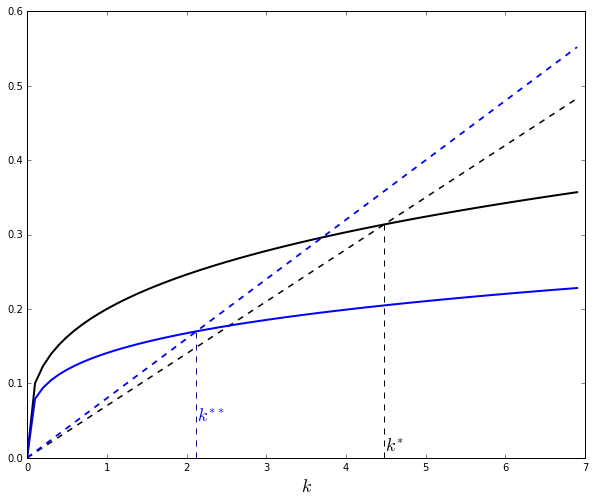

In [9]:
s1 = widgets.FloatSlider(min=max(0,s-0.05),max=min(1,s+0.05),step=0.01,value=s,description=r"$s_1$",continuous_update=True)
n1 = widgets.FloatSlider(min=0,max=n+0.05,step=0.01,value=n,description=r"$n_1$",continuous_update=True) 
delta1 = widgets.FloatSlider(min=0.02,max=delta+0.05,step=0.01,value=delta,description=r"$\delta_1$",continuous_update=True) 
A1 = widgets.FloatSlider(min=0.01,max=A+0.2,step=0.01,value=A,description=r"$A_1$",continuous_update=True)
alpha1 = widgets.FloatSlider(min=alpha-0.1,max=alpha+0.1,step=0.01,value=alpha,description=r"$\alpha_1$",continuous_update=True)

wPFD = interactive(plotPFandDepr,
                s0 = fixed(s),
                n0 = fixed(n),
                delta0 = fixed(delta), 
                A0 = fixed(A),
                alpha0 = fixed(alpha),
                s1 = s1,
                n1 = n1, 
                delta1 = delta1, 
                A1 = A1,
                alpha1 = alpha1,
                kmax = fixed(np.max(k)),
                __manual=True)
wPFD.children[-1].description = "Покажи"
display(wPFD)

## Динамика на капитала на глава от населението

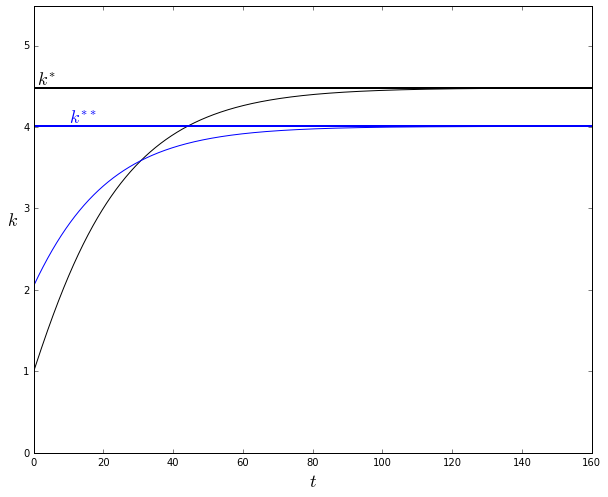

In [10]:
kinit1b = widgets.FloatSlider(min=max(0,k0-0.05),max=k0+5,step=0.01,value=k0,description=r"$k_{0,1}$",continuous_update=True)
s1b = widgets.FloatSlider(min=max(0,s-0.05),max=min(1,s+0.05),step=0.01,value=s,description=r"$s_1$",continuous_update=True)
n1b = widgets.FloatSlider(min=0,max=n+0.04,step=0.01,value=n,description=r"$n_1$",continuous_update=True) 
delta1b = widgets.FloatSlider(min=0.02,max=delta+0.05,step=0.01,value=delta,description=r"$\delta_1$",continuous_update=True) 
A1b = widgets.FloatSlider(min=0.01,max=A+0.2,step=0.01,value=A,description=r"$A_1$",continuous_update=True)
alpha1b = widgets.FloatSlider(min=alpha-0.1,max=alpha+0.1,step=0.01,value=alpha,description=r"$\alpha_1$",continuous_update=True)
Tmaxb = widgets.BoundedFloatText(min=0.1,max=Tmax+200,step=0.01,value=Tmax,description=r"$T$",continuous_update=True)

wSSols = interactive(SolowSols,
                kinit0 = fixed(k0),
                s0 = fixed(s),
                n0 = fixed(n),
                delta0 = fixed(delta), 
                A0 = fixed(A),
                alpha0 = fixed(alpha),
                kinit1 = kinit1b,
                s1 = s1b,
                n1 = n1b, 
                delta1 = delta1b, 
                A1 = A1b,
                alpha1 = alpha1b,
                Tmax = Tmaxb,
                f=fixed(f),
                kmax = fixed(np.max(k)),
                __manual=True)
wSSols.children[-1].description = "Покажи"
display(wSSols)

## Спестявания, максимизиращи потреблението: "златното правило" за коефициента на спестявания

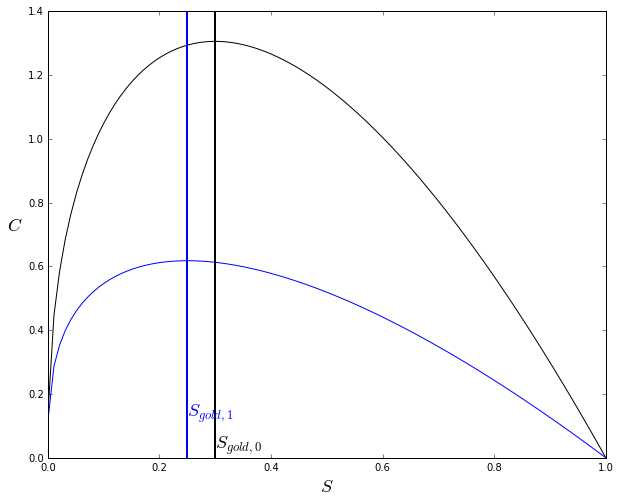

In [11]:
n1a = widgets.FloatSlider(min=0,max=n+0.04,step=0.01,value=n,description=r"$n_1$",continuous_update=True) 
delta1a = widgets.FloatSlider(min=0.02,max=delta+0.05,step=0.01,value=delta,description=r"$\delta_1$",continuous_update=True) 
A1a = widgets.FloatSlider(min=0.01,max=A+0.2,step=0.01,value=A,description=r"$A_1$",continuous_update=True)
alpha1a = widgets.FloatSlider(min=alpha-0.1,max=alpha+0.1,step=0.01,value=alpha,description=r"$\alpha_1$",continuous_update=True)

wPFD = interactive(plotConsToScompare,
                n0 = fixed(n),
                delta0 = fixed(delta), 
                A0 = fixed(A),
                alpha0 = fixed(alpha),
                n1 = n1a, 
                delta1 = delta1a, 
                A1 = A1a,
                alpha1 = alpha1a,
                f=fixed(f),
                maxk = fixed(np.max(k)),
                __manual=True)
wPFD.children[-1].description = "Покажи"
display(wPFD)